In [19]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta

fake = Faker('pl_PL')
Faker.seed(0)
np.random.seed(0)
random.seed(0)

T0_date = datetime.strptime('2015-01-01', '%Y-%m-%d').date() 
T1_date = datetime.strptime('2020-01-01', '%Y-%m-%d').date() 
T2_date = datetime.strptime('2025-01-01', '%Y-%m-%d').date()  

#To generate 1 milion houses, wit buying and selling set it to 
SCALE = 1
#SCALE = 4000

In [20]:
def push_to_file(file_name, data):
    with open(file_name, 'w') as file:
        for row in data:
            line = '|'.join(str(value) for value in row)
            file.write(line + '\n')

In [21]:
NUM_PEOPLE_T1 = 20 * SCALE 
NUM_PEOPLE_T2 = 40 * SCALE
persons = []
for i in range(NUM_PEOPLE_T2):
    if i == NUM_PEOPLE_T1:
         push_to_file('T1_Person.bulk', persons)
         
    persons.append([
        i+1, 
        fake.first_name(), 
        fake.last_name(), 
        str(random.randint(100000000, 999999999)),
        fake.email(), 
        fake.address().replace('\n', ', ')
    ])
push_to_file('T2_Person.bulk', persons)
del persons

In [22]:
NUM_EMPLOYEES_T1 = int(NUM_PEOPLE_T1 / 5)
NUM_EMPLOYEES_T2 = int(NUM_PEOPLE_T2 / 5)

NUM_OF_CLIENTS_AT_THAT_TIME = 0

employees = []
salesman_t1 = []
salesman_t2 = []

for i in range(NUM_EMPLOYEES_T2):
    if NUM_EMPLOYEES_T1 == i :
        push_to_file('T1_employees.bulk', employees)
        NUM_OF_CLIENTS_AT_THAT_TIME = NUM_PEOPLE_T1 - NUM_EMPLOYEES_T1

    EmployeeID = i + 1
    PersonID = i + 1 + NUM_OF_CLIENTS_AT_THAT_TIME
    title = random.choice(['Salesman', 'Manager', 'HR', 'Accountant', 'IT'])
    if i == 0:
        title = 'Salesman'
    
    if title == 'Salesman':
        if i < NUM_EMPLOYEES_T1:
            salesman_t1.append([EmployeeID])
        
        salesman_t2.append([EmployeeID])

    employees.append([
        EmployeeID,
        PersonID,
        title,
        round(random.uniform(30000, 80000))
    ])
push_to_file('T2_employees.bulk', employees)
del employees

In [23]:
NUM_PROPERTIES_T1 = 100 * SCALE
NUM_PROPERTIES_T2 = 200 * SCALE
properties = []

amenities_list = [
    "WiFi", "Parking", "Balcony", "Garden", "Air Conditioning", 
    "Heating", "Fireplace", "Swimming Pool", "Dishwasher", 
    "Washer", "Dryer", "Elevator", "Gym", "Pet Friendly"
]

price_list = []
for i in range(NUM_PROPERTIES_T2):
    if i == NUM_PROPERTIES_T1:
            push_to_file('T1_properties.bulk', properties)
    price = round(random.uniform(100000, 1000000))
    price_list.append([price])

    properties.append([
        i+1, 
        ', '.join(random.sample(amenities_list, k=random.randint(3, 6))),
        fake.address().replace('\n', ', '),
        random.choice(['House', 'Apartment']),
        price
    ])

push_to_file('T2_properties.bulk', properties)
del properties

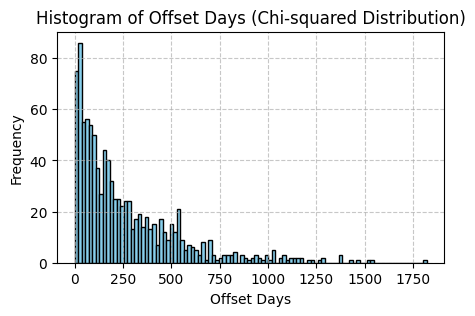

In [24]:
import matplotlib.pyplot as plt

starting_period = T0_date
ending_period = T1_date - timedelta(days=1)

df = 3 
num_simulations = 1000
offsets = []

for _ in range(num_simulations):
    buy_date = fake.date_between(start_date=starting_period, end_date=ending_period)
    date_range_days = (ending_period - buy_date).days

    if date_range_days <= 0:
        offsets.append(0)
        continue
    
    chi2_sample = min(np.random.chisquare(df) / 10, 1.0)
    offset_days = int(chi2_sample * date_range_days)
    offsets.append(offset_days)

# Plot histogram
plt.figure(figsize=(5, 3))
plt.hist(offsets, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Offset Days (Chi-squared Distribution)')
plt.xlabel('Offset Days')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
del offsets

In [26]:
NUM_OF_ACQUISITIONS_T1 = NUM_PROPERTIES_T1
NUM_OF_ACQUISITIONS_T2 = NUM_PROPERTIES_T2

acq = []
sale_t1 = []
sale_t2 = []
starting_period = T0_date
ending_period = T1_date - timedelta(days=1)

employee_cout = NUM_EMPLOYEES_T1
people_count = NUM_PEOPLE_T1

range1 = range(NUM_EMPLOYEES_T1 + 1, NUM_PEOPLE_T1)  # inclusive
range2 = range(NUM_PEOPLE_T1 + (NUM_EMPLOYEES_T2 - NUM_EMPLOYEES_T1) + 1, NUM_PEOPLE_T2)  # inclusive
combined_ranges = list(range1)

saleID_count = 0

def save_sale(case, SaleID, PropertyID, FK_Person, FK_Employee, SalePrice, SaleDate):
    if case == 1:
        sale_t1.append((SaleID,
                        PropertyID,
                        FK_Person,
                        FK_Employee,
                        SalePrice, 
                        SaleDate))
    elif case == 2:
        sale_t2.append((SaleID,
                        PropertyID,
                        FK_Person,
                        FK_Employee,
                        SalePrice, 
                        SaleDate))
    elif case == 3:
        save_sale(1, SaleID, PropertyID, FK_Person, FK_Employee, SalePrice, SaleDate)
        save_sale(2, SaleID, PropertyID, FK_Person, FK_Employee, SalePrice, SaleDate)


for i in range(NUM_OF_ACQUISITIONS_T2):
    if i == NUM_OF_ACQUISITIONS_T1:
        push_to_file('T1_acquisitions.bulk', acq)
        push_to_file('T1_sales.bulk', sale_t1)
        starting_period = T1_date
        ending_period = T2_date - timedelta(days=1)
        employee_cout = NUM_EMPLOYEES_T2
        people_count = NUM_PEOPLE_T2
        combined_ranges = list(range1) + list(range2)
        
    buy_date = fake.date_between(start_date=starting_period, end_date=ending_period)

    Buying_price = round(price_list[i][0] * random.uniform(0.7, 1.05))
    PropertyID = i+1
    FK_Person_buying = random.choice(combined_ranges)
    FK_Employee = None

    if i < NUM_EMPLOYEES_T1:
        FK_Employee = random.choice(salesman_t1)[0]
    else:
        FK_Employee = random.choice(salesman_t2)[0]
        
    acq.append([
            i + 1,
            PropertyID, # PropertyID                FK_Person_buying, # FK_Person becouse we assume that person is not the employee
            FK_Employee, # FK_Employee
            Buying_price,
            buy_date
            ])

    offset_days = int(chi2_sample * date_range_days)
    sale_date = buy_date + timedelta(days=offset_days)
    sale_price = round(price_list[i][0] * float(random.uniform(0.95, 1.2)))

    FK_Person_selling = random.choice(combined_ranges)
    if i < NUM_EMPLOYEES_T1:
        FK_Employee = random.choice(salesman_t1)[0]
    else:
        FK_Employee = random.choice(salesman_t2)[0]
        
    if sale_date < T1_date:
        saleID_count = saleID_count + 1
        save_sale(3, saleID_count, PropertyID, FK_Person_selling, FK_Employee, sale_price, sale_date)
    elif sale_date < T2_date:
        saleID_count = saleID_count + 1
        save_sale(2, saleID_count, PropertyID, FK_Person_selling, FK_Employee, sale_price, sale_date)

push_to_file('T2_acquisitions.bulk', acq)
push_to_file('T2_sales.bulk', sale_t2)
